In [20]:
import os
import glob
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve

from skimage.filters import threshold_otsu

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import pickle

In [21]:
# =========================================================
# 1. RUN-LENGTH ENCODING
# =========================================================
def binary_runlength_vector(binary_img, max_len=4096):
    """
    Convert a 2D binary image (values 0 or 1) into a 1D run-length vector:
        [n0, n1, n0, n1, ...]
    where n0 = count of zeros, n1 = count of ones, starting from the FIRST pixel.
    
    If the first pixel is 1, we start with 0 zeros, e.g. [0, n1, n0, n1, ...].
    
    The output is padded or truncated to length max_len.
    """
    flat = binary_img.flatten()  # shape: (H*W,)

    # Safety: if completely empty or weird array
    if flat.size == 0:
        return np.zeros(max_len, dtype=np.float32)

    runs = []           # will store the lengths (n0, n1, n0, ...)
    current = flat[0]   # current pixel of image
    count = 1

    for v in flat[1:]:      # v iterates through every pixel except the first
        if v == current:
            count += 1
        else:
            runs.append(count)
            current = v
            count = 1
    runs.append(count)

    # Ensure we always start with "zeros count"
    if flat[0] == 1:
        runs = [0] + runs

    # Pad or truncate to fixed length
    if len(runs) < max_len:
        runs = runs + [0] * (max_len - len(runs))
    else:
        runs = runs[:max_len]

    # convert list to numpy array + normalise by image size so counts are 0-1
    img_size = binary_img.shape[0] * binary_img.shape[1]
    runs = np.array(runs, dtype=np.float32) / float(img_size)

    return runs     # Returns new feature vector


In [22]:
# =========================================================
# 2. LOAD DATASET WITH RLE FEATURES
# =========================================================
def load_palm_vein_dataset_rle(
    data_root="Multispectral Palmprint Database/NIR",
    img_size=(256, 256),
    num_persons=30,
    max_len=4096
):
    """
    Loads NIR palm images and converts each to a run-length feature vector.
    """
    X = []
    y = []
    label_names = []

    all_dirs = sorted(
        d for d in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, d))
    )
    person_dirs = all_dirs[:num_persons]

    print(f"Using these persons: {person_dirs}")

    for label_idx, person in enumerate(person_dirs):
        label_names.append(person)
        folder = os.path.join(data_root, person)

        img_paths = []
        for ext in ("*.bmp", "*.png", "*.jpg", "*.jpeg", "*.tif", "*.tiff"):
            img_paths.extend(glob.glob(os.path.join(folder, ext)))

        if not img_paths:
            print(f"Warning: no images found in {folder}")
            continue

        for path in img_paths:
            # 1) Load + grayscale + resize
            img = Image.open(path).convert("L")
            img = img.resize(img_size)

            # 2) To float32 in [0,1]
            arr = np.array(img, dtype=np.float32) / 255.0

            # 3) Otsu threshold (per image)
            th = threshold_otsu(arr)
            binary = (arr >= th).astype(np.uint8)

            # 4) Run-length feature vector
            feat = binary_runlength_vector(binary, max_len=max_len)

            X.append(feat)
            y.append(label_idx)

    X = np.stack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    return X, y, label_names


In [23]:
# =========================================================
# 3. MAIN PIPELINE
# =========================================================
# 3.1 Load RLE data
max_len = 8192
X_rle, y_rle, label_names_rle = load_palm_vein_dataset_rle(
    data_root="Multispectral Palmprint Database/NIR",
    img_size=(256, 256),
    num_persons=30,
    max_len=max_len,
)
print("X_rle shape:", X_rle.shape)   # (N_samples, max_len)
print("y_rle shape:", y_rle.shape)
print("#classes:", len(label_names_rle))

num_classes_rle = len(label_names_rle)

# 3.2 Train/test split
X_train_rle, X_test_rle, y_train_rle, y_test_rle = train_test_split(
    X_rle, y_rle, test_size=0.2, stratify=y_rle, random_state=42
)
print("Train size:", X_train_rle.shape[0], "Test size:", X_test_rle.shape[0])

# 3.3 Standardization
scaler_rle = StandardScaler()
X_train_rle_scaled = scaler_rle.fit_transform(X_train_rle)
X_test_rle_scaled = scaler_rle.transform(X_test_rle)


Using these persons: ['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030']
X_rle shape: (360, 8192)
y_rle shape: (360,)
#classes: 30
Train size: 288 Test size: 72


In [24]:
# =========================================================
# 4. BUILD MLP MODEL (TensorFlow/Keras)
# =========================================================
def build_mlp_rle_model(input_dim, num_classes):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        # you can add more layers if you want:
        # layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


model_rle_tf = build_mlp_rle_model(input_dim=max_len, num_classes=num_classes_rle)
model_rle_tf.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,052,574 (4.02 MB)

 Trainable params: 1,052,574 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# =========================================================
# 5. TRAIN MODEL
# =========================================================
batch_size = 32
epochs = 50

early_stop_rle = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_rle = model_rle_tf.fit(
    X_train_rle_scaled, y_train_rle,
    validation_data=(X_test_rle_scaled, y_test_rle),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stop_rle],
    verbose=2
)

# =========================================================
# 6. SAVE MODEL + SCALER + LABELS
# =========================================================
model_rle_path = "palm_mlp_rle_tf.h5"
model_rle_tf.save(model_rle_path)
print(f"TensorFlow RLE model saved to: {model_rle_path}")

meta_rle_path = "palm_rle_scaler_labelmeta.pkl"
with open(meta_rle_path, "wb") as f:
    pickle.dump(
        {
            "scaler_rle": scaler_rle,
            "label_names_rle": label_names_rle,
            "max_len": max_len
        },
        f
    )
print(f"Scaler + label names saved to: {meta_rle_path}")

Epoch 1/50
9/9 - 1s - 108ms/step - accuracy: 0.1146 - loss: 3.1972 - val_accuracy: 0.2639 - val_loss: 2.7096
Epoch 2/50
9/9 - 0s - 18ms/step - accuracy: 0.6736 - loss: 1.5624 - val_accuracy: 0.4028 - val_loss: 2.2332
Epoch 3/50
9/9 - 0s - 17ms/step - accuracy: 0.9410 - loss: 0.7521 - val_accuracy: 0.4306 - val_loss: 2.0221
Epoch 4/50
9/9 - 0s - 17ms/step - accuracy: 0.9965 - loss: 0.3366 - val_accuracy: 0.5000 - val_loss: 1.9139
Epoch 5/50
9/9 - 0s - 20ms/step - accuracy: 1.0000 - loss: 0.1540 - val_accuracy: 0.5000 - val_loss: 1.8313
Epoch 6/50
9/9 - 0s - 19ms/step - accuracy: 1.0000 - loss: 0.0811 - val_accuracy: 0.5000 - val_loss: 1.7956
Epoch 7/50
9/9 - 0s - 18ms/step - accuracy: 1.0000 - loss: 0.0530 - val_accuracy: 0.4722 - val_loss: 1.7774
Epoch 8/50
9/9 - 0s - 20ms/step - accuracy: 1.0000 - loss: 0.0387 - val_accuracy: 0.4722 - val_loss: 1.7668
Epoch 9/50
9/9 - 0s - 19ms/step - accuracy: 1.0000 - loss: 0.0307 - val_accuracy: 0.4722 - val_loss: 1.7535
Epoch 10/50
9/9 - 0s - 17ms

TensorFlow RLE model saved to: palm_mlp_rle_tf.h5
Scaler + label names saved to: palm_rle_scaler_labelmeta.pkl


In [26]:
# =========================================================
# 7. PRINT TRAIN + TEST METRICS, EVALUATE, REPORTS
# =========================================================
# Final train loss & accuracy from history
final_train_loss_rle = history_rle.history["loss"][-1]
final_train_acc_rle = history_rle.history["accuracy"][-1]

# Test metrics from evaluate()
test_loss_rle, test_acc_rle = model_rle_tf.evaluate(X_test_rle_scaled, y_test_rle, verbose=0)

print("\n================ FINAL METRICS (RLE) ================")
print(f"Train Loss (RLE):     {final_train_loss_rle:.4f}")
print(f"Train Accuracy (RLE): {final_train_acc_rle:.4f}")
print(f"Test  Loss  (RLE):    {test_loss_rle:.4f}")
print(f"Test  Accuracy (RLE): {test_acc_rle:.4f}")
print("=====================================================\n")

# Predictions for detailed metrics
y_test_proba_rle = model_rle_tf.predict(X_test_rle_scaled, verbose=0)
y_test_pred_rle = np.argmax(y_test_proba_rle, axis=1)

print("Classification report (test set, RLE):")
print(classification_report(y_test_rle, y_test_pred_rle, target_names=label_names_rle))

cm_rle = confusion_matrix(y_test_rle, y_test_pred_rle)
print("Confusion matrix (test set, RLE):")
print(cm_rle)



================ FINAL METRICS (RLE) ================
Train Loss (RLE):     0.0069
Train Accuracy (RLE): 1.0000
Test  Loss  (RLE):    1.7349
Test  Accuracy (RLE): 0.4861

Classification report (test set, RLE):
              precision    recall  f1-score   support

        0001       0.50      1.00      0.67         2
        0002       1.00      0.50      0.67         2
        0003       0.00      0.00      0.00         2
        0004       0.50      0.33      0.40         3
        0005       0.33      0.50      0.40         2
        0006       0.00      0.00      0.00         2
        0007       1.00      0.33      0.50         3
        0008       0.50      1.00      0.67         3
        0009       1.00      0.50      0.67         2
        0010       0.25      0.50      0.33         2
        0011       0.67      0.67      0.67         3
        0012       1.00      0.50      0.67         2
        0013       0.25      0.50      0.33         2
        0014       0.00      0.0

c:\Users\kxy\miniconda3\envs\py10\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kxy\miniconda3\envs\py10\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kxy\miniconda3\envs\py10\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


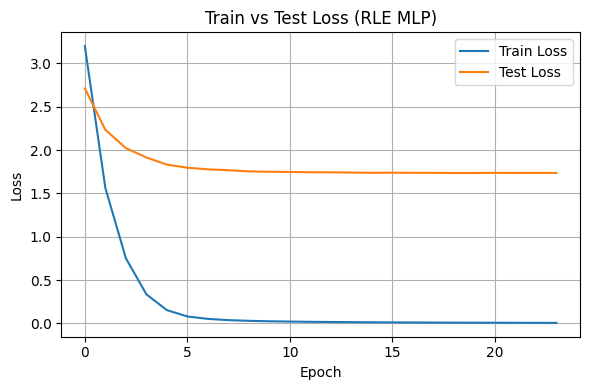

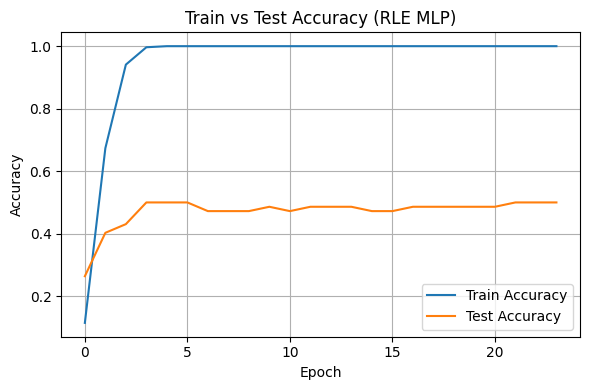

<Figure size 600x600 with 0 Axes>

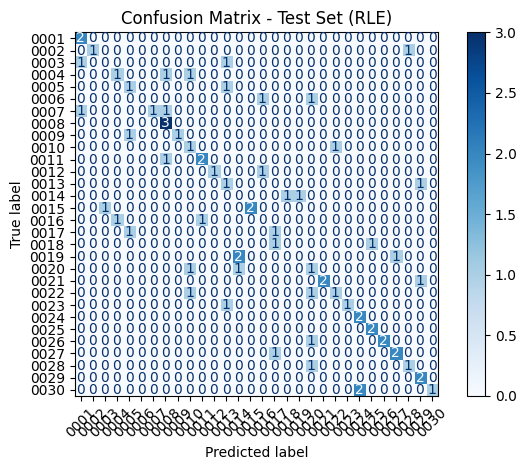

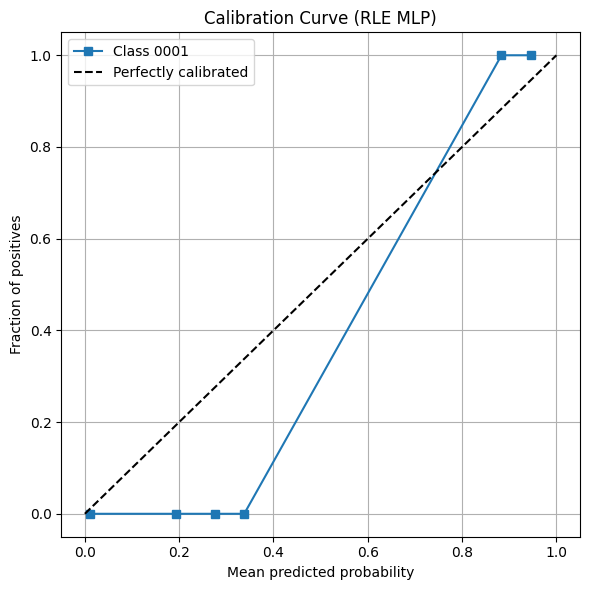

In [27]:
# =========================================================
# 8. PLOTS
# =========================================================

# 8.1 Train vs Test loss curve
plt.figure(figsize=(6, 4))
plt.plot(history_rle.history["loss"], label="Train Loss")
plt.plot(history_rle.history["val_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss (RLE MLP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8.2 Train vs Test accuracy curve
plt.figure(figsize=(6, 4))
plt.plot(history_rle.history["accuracy"], label="Train Accuracy")
plt.plot(history_rle.history["val_accuracy"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy (RLE MLP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8.3 Confusion matrix plot
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rle, display_labels=label_names_rle)
disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
plt.title("Confusion Matrix - Test Set (RLE)")
plt.tight_layout()
plt.show()

# 8.4 Calibration curve for one class
class_id = 0  # choose any class to visualise calibration
y_true_binary_rle = (y_test_rle == class_id).astype(int)
y_prob_class_rle = y_test_proba_rle[:, class_id]

prob_true_rle, prob_pred_rle = calibration_curve(
    y_true_binary_rle, y_prob_class_rle, n_bins=10, strategy="uniform"
)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred_rle, prob_true_rle, "s-", label=f"Class {label_names_rle[class_id]}")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (RLE MLP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# =========================================================
# 9. VERIFICATION
# =========================================================
def verify_image_rle_tf(
    model,
    scaler,
    img_path,
    claimed_person_name,
    label_names,
    img_size=(256, 256),
    max_len=8192,
    bin_thresh=0.5,
    threshold=None
):
    """
    Verify if image at img_path belongs to claimed_person_name
    using RLE + Keras MLP model.

    Steps:
      - Load + grayscale + resize
      - Normalise to [0,1]
      - Threshold to binary (using bin_thresh)
      - Run-length encode -> feature vector
      - Standardize with the same scaler as training
      - Predict with Keras model (softmax probabilities)
    """
    # 1) Load + preprocess image
    img = Image.open(img_path).convert("L").resize(img_size)
    arr = np.array(img, dtype=np.float32) / 255.0

    # NOTE: training used Otsu; here we keep your original verify style (fixed threshold)
    binary = (arr >= bin_thresh).astype(np.uint8)

    # 2) RLE feature
    feat = binary_runlength_vector(binary, max_len=max_len).reshape(1, -1)

    # 3) Standardize using training scaler
    feat_scaled = scaler.transform(feat)

    # 4) Predict probabilities
    y_proba = model.predict(feat_scaled, verbose=0)[0]  # (num_classes,)
    pred_class = int(np.argmax(y_proba))
    pred_name = label_names[pred_class]
    proba = float(y_proba[pred_class])

    # 5) Match decision
    if threshold is not None:
        is_match = (pred_name == claimed_person_name) and (proba >= threshold)
    else:
        is_match = (pred_name == claimed_person_name)

    return is_match, pred_name, proba


# ---- TEST VERIFICATION ----
test_img_path = "Multispectral Palmprint Database/NIR/0020/2_01.jpg"

is_match, pred_name, prob = verify_image_rle_tf(
    model=model_rle_tf,
    scaler=scaler_rle,
    img_path=test_img_path,
    claimed_person_name="0020",
    label_names=label_names_rle,
    img_size=(256, 256),
    max_len=max_len,
    bin_thresh=0.5,   # you can change or re-use Otsu if you want
    threshold=None
)

print("Match:", is_match)
print("Predicted class:", pred_name)
print("Probability:", prob)


Match: False
Predicted class: 0002
Probability: 1.0
